# **Load Libraries**

In [ ]:
import numpy as np
import pandas as pd
import datetime
import pandas as pd
from pandas import read_csv
#from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# **Load Dataset**

In [ ]:
data_path = '/content/21-22 Covid Cases&Deaths.csv'
series = pd.read_csv(data_path)

In [ ]:
series.head()

,State,Year,Month,Deaths,Cases
0,AK,2021,1,8371,1568946
1,AK,2021,2,8234,1561458
2,AK,2021,3,9750,1861151
3,AK,2021,4,9927,1944823
4,AK,2021,5,10990,2112427


In [ ]:
series.dropna()

,State,Year,Month,Deaths,Cases
0,AK,2021,1,8371,1568946
1,AK,2021,2,8234,1561458
2,AK,2021,3,9750,1861151
3,AK,2021,4,9927,1944823
4,AK,2021,5,10990,2112427
...,...,...,...,...,...
1219,WY,2022,8,57902,5360153
1220,WY,2022,9,56622,5272096
1221,WY,2022,10,59001,5509116
1222,WY,2022,11,57678,5391322


# **Plotting the Actual Data**

The code below aggregates monthly COVID-19 cases by year, formats the data for clear Year-Month labeling, and visualizes it as a line plot with custom x-axis and layout using Plotly Express.

In [ ]:
# Group data by year and month to sum up cases for each month
monthly_cases = series.groupby(['Year', 'Month'])['Cases'].sum().reset_index()

# Format x-axis labels to show year and month
monthly_cases['Year-Month'] = monthly_cases['Year'].astype(str) + '-' + monthly_cases['Month'].astype(str).str.zfill(2)

# Plot using Plotly Express
fig = px.line(
    monthly_cases,
    x='Year-Month',
    y='Cases',
    color='Year',
    title='Monthly COVID-19 Cases in 2021 and 2022',
    labels={'Year-Month': 'Month', 'Cases': 'Number of Cases'},
    markers=True
)

# Customize the x-axis and layout
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=monthly_cases['Year-Month'],
        ticktext=monthly_cases['Year-Month'],
        tickangle=45
    ),
    yaxis_title="Number of Cases",
    legend_title="Year",
    template="plotly_white"
)

fig.show()

In [ ]:
# Group data by year and month to sum up deaths for each month
monthly_deaths = series.groupby(['Year', 'Month'])['Deaths'].sum().reset_index()

# Format x-axis labels to show year and month
monthly_deaths['Year-Month'] = monthly_deaths['Year'].astype(str) + '-' + monthly_deaths['Month'].astype(str).str.zfill(2)

# Plot using Plotly Express
fig = px.line(
    monthly_deaths,
    x='Year-Month',
    y='Deaths',
    color='Year',
    title='Monthly COVID-19 Deaths in 2021 and 2022',
    labels={'Year-Month': 'Month', 'Deaths': 'Number of Deaths'},
    markers=True
)

# Customize the x-axis and layout
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=monthly_deaths['Year-Month'],
        ticktext=monthly_deaths['Year-Month'],
        tickangle=45
    ),
    yaxis_title="Number of Deaths",
    legend_title="Year",
    template="plotly_white"
)

fig.show()

# **ARIMA Modeling For Cases**



- This code fits an ARIMA model to forecast COVID-19 cases for 2022 based on monthly case data from 2021, combines actual and forecasted data into a single dataset, and visualizes the results in a line plot clearly distinguishing between actual and forecasted cases.

In [ ]:
# fit an ARIMA model and plot the forecasted data

# Filter data for 2021
data_2021 = series[series['Year'] == 2021].groupby('Month').agg({'Cases': 'sum', 'Deaths': 'sum'})

# Convert Month to a DateTime index
data_2021.index = pd.date_range(start='2021-01', periods=12, freq='ME')

# Fit ARIMA model directly on actual cases
model = ARIMA(data_2021['Cases'], order=(5, 1, 3))
model_fit = model.fit()

# Forecast cases
forecasted_cases = model_fit.forecast(steps=12)

# Create a DataFrame for forecasted cases
forecasted_months = pd.date_range(start='2022-01', periods=12, freq='ME')
forecasted_cases_df = pd.DataFrame({
    'Month': forecasted_months,
    'Cases': forecasted_cases
})

# Combine actual and forecasted data
actual_cases_df = data_2021[['Cases']].reset_index().rename(columns={'index': 'Month'})
actual_cases_df['Type'] = 'Actual 2021'
forecasted_cases_df['Type'] = 'Forecasted 2022'

# Concatenate the data
combined_data = pd.concat([actual_cases_df, forecasted_cases_df], ignore_index=True)

# Create a complete range of months from Jan 2021 to Dec 2022
all_months = pd.date_range(start='2021-01', end='2023-01', freq='ME')
combined_data = combined_data.set_index('Month').reindex(all_months).reset_index()
combined_data = combined_data.rename(columns={'index': 'Month'})

# Fill missing values for Type with forward or backward fill
combined_data['Type'] = combined_data['Type'].bfill()

# Plot the data using Plotly Express
fig = px.line(
    combined_data,
    x='Month',
    y='Cases',
    color='Type',
    title='Monthly COVID-19 Cases Forecast',
    labels={'Month': 'Month', 'Cases': 'Number of Cases'},
    markers=True
)

# Update the layout to include all months
fig.update_layout(
    xaxis=dict(
        tickvals=all_months,
        tickformat='%b-%Y',
        tickangle=45
    ),
    yaxis=dict(title='Number of Cases'),
    legend_title='Type'
)

fig.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



# **Rolling ForeCast**

The code below uses walk-forward validation to repeatedly train an ARIMA model on historical data (history), make a prediction for the next test value, and then update history with the actual observed value from the test set. This iterative process evaluates the model's forecasting accuracy by comparing predictions with actual values and visualizing the results.

predicted=16222870.259807, expected=19826758.000000
predicted=19841174.791514, expected=21680609.000000
predicted=21791587.233733, expected=24551172.000000
predicted=24526279.727887, expected=23877039.000000
predicted=24086883.958713, expected=24842605.000000
predicted=24784399.435716, expected=24502652.000000
predicted=24651961.788788, expected=26344122.000000
predicted=26255301.168813, expected=27632433.000000
predicted=27725987.390086, expected=27632751.000000
predicted=27646296.955486, expected=28840287.000000
predicted=28836501.506790, expected=28078903.000000
predicted=28190748.400715, expected=29322517.000000
predicted=29236277.964947, expected=2740021.000000
predicted=3405532.707177, expected=2725762.000000
predicted=1409772.859905, expected=3171003.000000
predicted=3780060.083305, expected=3203421.000000
predicted=2502863.847979, expected=3427644.000000
predicted=3369300.524229, expected=3387680.000000
predicted=3410503.250358, expected=3557473.000000
predicted=3548732.634467,

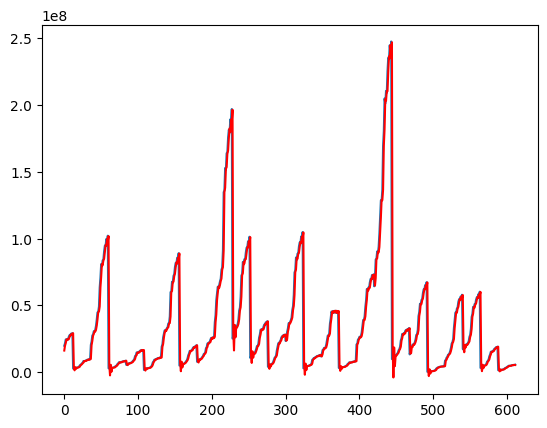

In [ ]:
# evaluate an ARIMA model using a walk-forward validation
X = series['Cases'].values
size = int(len(X) * 0.50)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1, 0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# **ARIMA Modeling For Deaths**


- This code fits an ARIMA model to forecast COVID-19 deaths for 2022 based on monthly deaths data from 2021, combines actual and forecasted data into a single dataset, and visualizes the results in a line plot clearly distinguishing between actual and forecasted deaths.

In [ ]:
# fit an ARIMA model and plot thre chart

# Filter data for 2021
data_2021 = series[series['Year'] == 2021].groupby('Month').agg({'Cases': 'sum', 'Deaths': 'sum'})

# Convert Month to a DateTime index
data_2021.index = pd.date_range(start='2021-01', periods=12, freq='ME')

# Fit ARIMA model directly on actual deaths
model = ARIMA(data_2021['Deaths'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast deaths
forecasted_deaths = model_fit.forecast(steps=12)

# Create a DataFrame for forecasted deaths
forecasted_months = pd.date_range(start='2022-01', periods=12, freq='ME')
forecasted_deaths_df = pd.DataFrame({
    'Month': forecasted_months,
    'Deaths': forecasted_deaths
})

# Combine actual and forecasted data
actual_deaths_df = data_2021[['Deaths']].reset_index().rename(columns={'index': 'Month'})
actual_deaths_df['Type'] = 'Actual'
forecasted_deaths_df['Type'] = 'Forecasted'

# Concatenate the data
combined_data = pd.concat([actual_deaths_df, forecasted_deaths_df], ignore_index=True)

# Create a complete range of months from Jan 2021 to Dec 2022
all_months = pd.date_range(start='2021-01', end='2023-01', freq='ME')
combined_data = combined_data.set_index('Month').reindex(all_months).reset_index()
combined_data = combined_data.rename(columns={'index': 'Month'})

# Fill missing values for Type with forward or backward fill
combined_data['Type'] = combined_data['Type'].bfill()

# Plot the data using Plotly Express
fig = px.line(
    combined_data,
    x='Month',
    y='Deaths',
    color='Type',
    title='Monthly COVID-19 Deaths Forecast',
    labels={'Month': 'Month', 'Deaths': 'Number of Deaths'},
    markers=True
)

# Update the layout to include all months
fig.update_layout(
    xaxis=dict(
        tickvals=all_months,
        tickformat='%b-%Y',
        tickangle=45
    ),
    yaxis=dict(title='Number of Deaths'),
    legend_title='Type'
)

fig.show()


# **Rolling Forecast**

predicted=320057.209817, expected=329896.000000
predicted=331387.317227, expected=325580.000000
predicted=326218.047814, expected=378438.000000
predicted=376414.121057, expected=372409.000000
predicted=375354.128272, expected=386141.000000
predicted=383760.655564, expected=374471.000000
predicted=376567.294169, expected=389154.000000
predicted=388568.300685, expected=394043.000000
predicted=395010.209625, expected=385325.000000
predicted=385368.938568, expected=401199.000000
predicted=400202.175540, expected=390239.000000
predicted=391914.539102, expected=404885.000000
predicted=403331.009072, expected=33897.000000
predicted=47930.713204, expected=37103.000000
predicted=21401.558320, expected=43505.000000
predicted=55811.547952, expected=45788.000000
predicted=38962.503739, expected=49497.000000
predicted=42538.241793, expected=49367.000000
predicted=49627.113069, expected=52221.000000
predicted=52154.112556, expected=54089.000000
predicted=54256.613305, expected=56310.000000
predicted

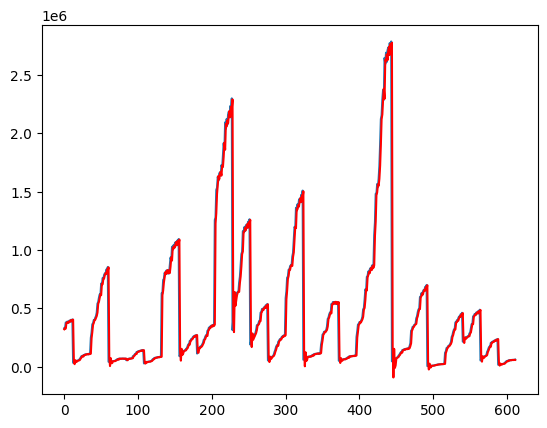

In [ ]:
# evaluate an ARIMA model using a walk-forward validation
X = series['Deaths'].values
size = int(len(X) * 0.50)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1, 0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# **Random Forest Modeling for Cases**

The code below trains a Random Forest Regressor on monthly COVID-19 case data with lagged features to predict cases for 2022. It visualizes the predictions alongside the training data in a line chart for trend comparison.

In [ ]:
data = series.groupby(['Year','Month'],as_index=False).agg({'Cases': 'sum'})
data_deaths = series.groupby(['Year','Month'],as_index=False).agg({'Deaths': 'sum'})

data = data.sort_values(by=['Year', 'Month'])

data['lag-1'] = data['Cases'].shift(1)
data['lag-2'] = data['Cases'].shift(2)
data['lag-3'] = data['Cases'].shift(3)


# Fill NaN values with the mean of the 'Cases' column
# data['lag-1'] = data['lag-1'].fillna(data['Cases'].mean())
# data['lag-2'] = data['lag-2'].fillna(data['Cases'].mean())
data = data.fillna(data.mean())


#Split the data
train_data = data[data.Year < 2022]
test_data = data[data.Year == 2022]

x_train = train_data[['Year','Month','lag-1','lag-2','lag-3']]
y_train = train_data['Cases']
x_test = test_data[['Year','Month','lag-1','lag-2','lag-3']]
y_test = test_data['Cases']

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(x_train, y_train)
y_hat = reg.predict(x_test)



# Create a date range for the training period
train_dates = pd.date_range(start='2021-01-01', periods=len(y_train), freq='ME')

# Create a date range for the prediction period
test_dates = pd.date_range(start='2022-01-01', periods=len(y_hat), freq='ME')

# Combine the data into a single DataFrame
train_data = pd.DataFrame({'Date': train_dates, 'Value': y_train, 'Type': 'Training'})
test_data = pd.DataFrame({'Date': test_dates, 'Value': y_hat, 'Type': 'Prediction'})
combined_data = pd.concat([train_data, test_data]).reset_index(drop=True)

# Plot the data using Plotly Express
fig = px.line(combined_data, x='Date', y='Value', color='Type',
              title='Monthly COVID-19 Cases Forecast',
              labels={'Date': 'Month', 'Value': 'Value'},
              markers=True)

# Customize the x-axis to show all months with labels rotated for better readability
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=pd.date_range(start='2021-01', end='2023-01', freq='ME'),
        ticktext=[d.strftime('%b-%Y') for d in pd.date_range(start='2021-01', end='2023-01', freq='ME')],
        tickangle=45
    ),
    yaxis_title='Number of Cases',
    legend_title='Data Type',
    template='plotly_white'
)

fig.show()

In [ ]:
# # We included state as part of the features

# # Group data by Year, Month, and State
# data = series.groupby(['Year', 'Month'], as_index=False).agg({'Cases': 'sum'})

# # # One-hot encode the State column using pd.get_dummies
# # state_encoded_df = pd.get_dummies(data['State'], prefix='State')
# # # Add one-hot encoded states to the data
# # data = pd.concat([data, state_encoded_df], axis=1)

# # Sort the data to maintain chronological order
# data = data.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# # lag features for the Cases column
# data['lag-1'] = data['Cases'].shift(1)
# data['lag-2'] = data['Cases'].shift(2)


# # Fill NaN values in lag features with the mean of the 'Cases' column for each state
# # data['lag-1'] = data['lag-1'].fillna(data['Cases'].mean())
# # data['lag-2'] = data['lag-2'].fillna(data['Cases'].mean())
# data = data.fillna(data.mean())


# # Split data into training (2021) and testing (2022) sets
# train_data = data[data['Year'] < 2022]
# test_data = data[data['Year'] == 2022]

# # Use State, Year, and Month as features for training and testing
# x_train = train_data[['Year','Month','lag-1','lag-2']] # + list(state_encoded_df.columns)]
# y_train = train_data['Cases']
# x_test = test_data[['Year','Month','lag-1','lag-2']] #+ list(state_encoded_df.columns)]
# y_test = test_data['Cases']

# # Train the Random Forest Regressor
# reg = RandomForestRegressor(n_estimators=100, random_state=42)
# reg.fit(x_train, y_train)
# y_hat = reg.predict(x_test)

# # Prepare the training data for plotting
# train_results = train_data.groupby(['Year', 'Month'], as_index=False).agg({'Cases': 'sum'})
# train_results['Type'] = 'Training'
# train_results['Date'] = pd.to_datetime(train_results[['Year', 'Month']].assign(DAY=1))

# # Prepare the predicted data for plotting
# test_results = test_data.copy()
# test_results['Cases'] = y_hat
# test_results = test_results.groupby(['Year', 'Month'], as_index=False).agg({'Cases': 'sum'})
# test_results['Type'] = 'Prediction'
# test_results['Date'] = pd.to_datetime(test_results[['Year', 'Month']].assign(DAY=1))

# # Combine training and prediction results
# combined_data = pd.concat([train_results, test_results], axis=0).reset_index(drop=True)

# # Generate a full range of dates for the x-axis
# all_dates = pd.date_range(start='2021-01-01', end='2022-12-31', freq='MS')

# # Plot the results
# fig = px.line(combined_data, x='Date', y='Cases', color='Type',
#               title='Monthly COVID-19 Cases Forecast',
#               labels={'Date': 'Month', 'Cases': 'Number of Cases'},
#               markers=True)

# # Update the x-axis to display all months
# fig.update_layout(
#     xaxis=dict(
#         tickvals=all_dates,
#         ticktext=[d.strftime('%b-%Y') for d in all_dates],
#         tickangle=45,
#         title='Month'
#     ),
#     yaxis_title='Number of Cases',
#     legend_title='Data Type',
#     template='plotly_white'
# )

# fig.show()

In [ ]:
data

,Year,Month,Cases,lag-1,lag-2,lag-3
0,2021,1,724340896,1.824338e+09,1.824338e+09,NaN
1,2021,2,763591262,7.243409e+08,1.824338e+09,NaN
2,2021,3,902051444,7.635913e+08,7.243409e+08,NaN
3,2021,4,929252645,9.020514e+08,7.635913e+08,7.243409e+08
4,2021,5,1003054388,9.292526e+08,9.020514e+08,7.635913e+08
5,2021,6,986820811,1.003054e+09,9.292526e+08,9.020514e+08
6,2021,7,1040470621,9.868208e+08,1.003054e+09,9.292526e+08
7,2021,8,1127283071,1.040471e+09,9.868208e+08,1.003054e+09
8,2021,9,1221618046,1.127283e+09,1.040471e+09,9.868208e+08
9,2021,10,1361513056,1.221618e+09,1.127283e+09,1.040471e+09


**Evaluate the Random Forest model For Cases**

In [ ]:
rmse = sqrt(mean_squared_error(y_test, y_hat))
r2 = r2_score(y_test, y_hat)
print(f"Evaluation Metrics for Random Forest Model:")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared (R²): {r2}")

Evaluation Metrics for Random Forest Model:
RMSE: 1289054221.84
R-squared (R²): -18.76576485162187


# **Random Forest Modeling for Deaths**

The code trains a Random Forest Regressor on monthly COVID-19 deaths data with lagged features to predict deaths for 2022. It visualizes the predictions alongside the training data in a line chart for trend comparison.

In [ ]:
data_deaths = series.groupby(['Year','Month'],as_index=False).agg({'Deaths': 'sum'})

data_deaths = data_deaths.sort_values(by=['Year', 'Month'])

data_deaths['lag-1'] = data_deaths['Deaths'].shift(1)
data_deaths['lag-2'] = data_deaths['Deaths'].shift(2)
data_deaths['lag-3'] = data_deaths['Deaths'].shift(3)


# Fill NaN values with the mean of the 'Deaths' column
data_deaths['lag-1'] = data_deaths['lag-1'].fillna(data_deaths['Deaths'].mean())
data_deaths['lag-2'] = data_deaths['lag-2'].fillna(data_deaths['Deaths'].mean())


#Split the data
train_data = data_deaths[data_deaths.Year < 2022]
test_data = data_deaths[data_deaths.Year == 2022]

x_train = train_data[['Year','lag-1','lag-2','lag-3']]
y_train = train_data['Deaths']
x_test = test_data[['Year','lag-1','lag-2','lag-3']]
y_test = test_data['Deaths']

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(x_train, y_train)
y_hat = reg.predict(x_test)


# Create a date range for the training period
train_dates = pd.date_range(start='2021-01-01', periods=len(y_train), freq='ME')

# Create a date range for the prediction period
test_dates = pd.date_range(start='2022-01-01', periods=len(y_hat), freq='ME')

# Combine the data into a single DataFrame
train_data = pd.DataFrame({'Date': train_dates, 'Value': y_train, 'Type': 'Training'})
test_data = pd.DataFrame({'Date': test_dates, 'Value': y_hat, 'Type': 'Prediction'})
combined_data = pd.concat([train_data, test_data]).reset_index(drop=True)

# Plot the data using Plotly Express
fig = px.line(combined_data, x='Date', y='Value', color='Type',
              title='Monthly COVID-19 Deaths Forecast',
              labels={'Date': 'Month', 'Value': 'Value'},
              markers=True)

# Customize the x-axis to show all months with labels rotated for better readability
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=pd.date_range(start='2021-01', end='2023-01', freq='ME'),
        ticktext=[d.strftime('%b-%Y') for d in pd.date_range(start='2021-01', end='2023-01', freq='ME')],
        tickangle=45
    ),
    yaxis_title='Number of Deaths',
    legend_title='Data Type',
    template='plotly_white'
)

fig.show()

In [ ]:
data_deaths

,Year,Month,Deaths,lag-1,lag-2,lag-3
0,2021,1,12646608,2.450358e+07,2.450358e+07,NaN
1,2021,2,13840585,1.264661e+07,2.450358e+07,NaN
2,2021,3,16757021,1.384058e+07,1.264661e+07,NaN
3,2021,4,16966911,1.675702e+07,1.384058e+07,12646608.0
4,2021,5,18101058,1.696691e+07,1.675702e+07,13840585.0
5,2021,6,17915298,1.810106e+07,1.696691e+07,16757021.0
6,2021,7,18771138,1.791530e+07,1.810106e+07,16966911.0
7,2021,8,19335535,1.877114e+07,1.791530e+07,18101058.0
8,2021,9,20053906,1.933554e+07,1.877114e+07,17915298.0
9,2021,10,22320429,2.005391e+07,1.933554e+07,18771138.0


In [ ]:
# # We included state as part of the features

# # Group data by Year, Month, and State
# data_deaths = series.groupby(['Year', 'Month', 'State'], as_index=False).agg({'Deaths': 'sum'})

# # One-hot encode the State column using pd.get_dummies
# state_encoded_df = pd.get_dummies(data_deaths['State'], prefix='State')

# # Add one-hot encoded states to the data
# data_deaths = pd.concat([data_deaths, state_encoded_df], axis=1)

# # Sort the data to maintain chronological order
# data_deaths = data_deaths.sort_values(by=['Year', 'Month', 'State']).reset_index(drop=True)

# # lag features for the Cases column
# data_deaths['lag-1'] = data_deaths.groupby('State')['Deaths'].shift(1)
# data_deaths['lag-2'] = data_deaths.groupby('State')['Deaths'].shift(2)
# data_deaths['lag-3'] = data_deaths.groupby('State')['Deaths'].shift(3)



# # Fill NaN values in lag features with the mean of the 'Cases' column for each state
# data_deaths['lag-1'] = data_deaths['lag-1'].fillna(data_deaths.groupby('State')['Deaths'].transform('mean'))
# data_deaths['lag-2'] = data_deaths['lag-2'].fillna(data_deaths.groupby('State')['Deaths'].transform('mean'))

# # Split data into training (2021) and testing (2022) sets
# train_data = data_deaths[data_deaths['Year'] < 2022]
# test_data = data_deaths[data_deaths['Year'] == 2022]

# # Use State, Year, and Month as features for training and testing
# x_train = train_data[['Year','lag-1','lag-2','lag-3'] + list(state_encoded_df.columns)]
# y_train = train_data['Deaths']
# x_test = test_data[['Year','lag-1','lag-2','lag-3'] + list(state_encoded_df.columns)]
# y_test = test_data['Deaths']

# # Train the Random Forest Regressor
# reg = RandomForestRegressor(n_estimators=100, random_state=42)
# reg.fit(x_train, y_train)
# y_hat = reg.predict(x_test)

# # Prepare the training data for plotting
# train_results = train_data.groupby(['Year', 'Month'], as_index=False).agg({'Deaths': 'sum'})
# train_results['Type'] = 'Training'
# train_results['Date'] = pd.to_datetime(train_results[['Year', 'Month']].assign(DAY=1))

# # Prepare the predicted data for plotting
# test_results = test_data.copy()
# test_results['Deaths'] = y_hat
# test_results = test_results.groupby(['Year', 'Month'], as_index=False).agg({'Deaths': 'sum'})
# test_results['Type'] = 'Prediction'
# test_results['Date'] = pd.to_datetime(test_results[['Year', 'Month']].assign(DAY=1))

# # Combine training and prediction results
# combined_data = pd.concat([train_results, test_results], axis=0).reset_index(drop=True)

# # Generate a full range of dates for the x-axis
# all_dates = pd.date_range(start='2021-01-01', end='2022-12-31', freq='MS')

# # Plot the results
# fig = px.line(combined_data, x='Date', y='Deaths', color='Type',
#               title='Monthly COVID-19 Deaths Forecast',
#               labels={'Date': 'Month', 'Deaths': 'Number of Deaths'},
#               markers=True)

# # Update the x-axis to display all months
# fig.update_layout(
#     xaxis=dict(
#         tickvals=all_dates,
#         ticktext=[d.strftime('%b-%Y') for d in all_dates],
#         tickangle=45,
#         title='Month'
#     ),
#     yaxis_title='Number of Deaths',
#     legend_title='Data Type',
#     template='plotly_white'
# )

# fig.show()

**Evaluate the Random Forest model For Deaths**

In [ ]:
rmse = sqrt(mean_squared_error(y_test, y_hat))
r2 = r2_score(y_test, y_hat)

print(f"Evaluation Metrics for Random Forest Model:")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared (R²): {r2}")

Evaluation Metrics for Random Forest Model:
RMSE: 7706208.60
R-squared (R²): -11.529971722293729
